# 3.9 AutoML

Automated workflow for hyper-parameter tuning and optimal model finder

In this tutorial, we will try some cool technique that has been used widely to make AI/ML less tedious and boost your ML workflow efficiency. 

If you have learnt [3.6](3.6_randomForest_regression.ipynb), you might be amazed but also annoyed by all those parameter tuning efforts and many back-n-forth iterations needed to figure out which configuration will be optimal for your case. It has been known as the major reason for low productivity in the AI/ML world. People come up with an idea that it seems most work in that tuning and iteration are very simple, can we automate it? The answer is yes, and that will be the technique we will introduce here: AutoML.

There are many AutoML solutions on the market, e.g., AutoKeras, auto-sklearn, H2O, Auto-WEKA, etc. Here we will focus on [PyCaret](https://pycaret.gitbook.io/docs/get-started/installation) which is a popular one in both academia and industry and very easy to use.


In the following tutorial, we will use the Pycaret Docker Image to run the tutorial. In Terminal, call ``docker`` to pull the PyCaret image and start a jupyter notebook:

```
docker pull pycaret/full
docker run -it -p 8888:8888 -e GRANT_SUDO=yes pycaret/full
```

You will then be able to edit a notebook with the following cells:


## First we get data ready

As usual, data collection is the first step. To better demonstrate the point of AutoML, we will use the same data as [3.6 Random Forest](3.6_randomForest_regression.ipynb).

In [1]:
pip install wget

  Using cached wget-3.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wget
wget.download("https://docs.google.com/uc?export=download&id=1pko9oRmCllAxipZoa3aoztGZfPAD2iwj")

'temps.csv'

## Display the data columns

Show the columns and settle on the target variables and the input variables. In this chapter, we will use 

In [3]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('temps.csv')
features.columns

Index(['year', 'month', 'day', 'week', 'temp_2', 'temp_1', 'average', 'actual',
       'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend'],
      dtype='object')

- Temp_2 : Maximum temperature on 2 days prior to today.

- Temp_1: Maximum temperature on yesterday.

- Average: Historical temperature average

- Actual: Actual measure temperature on today.

- Forecast_NOAA: Temperature values forecasted by NOAA

- Friend: Forecasted by Friend (Randomly selected number within plus-minus 20 of Average temperature)

We will use the `actual` as the label, and all the other variables as features. 

# Check the data shape


In [4]:
features.shape

(348, 12)

In [5]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)
# Display the first 5 rows of the last 12 columns
features.iloc[:,5:].head(5)

,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,46.0,44,46,46,46,41,0,0,0,0,0,1,0


# Split training and testing

As we already did all the quality checks in [3.6](3.6_randomForest_regression.ipynb), we will not repeat them here and directly go to AutoML experiment. First, split the data into training and testing subsets.

In [6]:
train_df = features[:300]
test_df = features[300:]
print('Data for Modeling: ' + str(train_df.shape))
print('Unseen Data For Predictions: ' + str(test_df.shape))

Data for Modeling: (300, 18)
Unseen Data For Predictions: (48, 18)


In [7]:
train_df

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2016,11,9,63,71,52.4,65,48,56,52,42,0,0,0,0,0,0,1
296,2016,11,10,71,65,52.2,64,52,54,51,38,0,0,0,0,1,0,0
297,2016,11,11,65,64,51.9,63,50,53,52,55,1,0,0,0,0,0,0
298,2016,11,12,64,63,51.7,59,50,52,52,63,0,0,1,0,0,0,0


# Run PyCaret (no hassle)

Directly get to the point. Expect PyCaret to tell you what is going wrong. It should be able to automatically recognize the columns and assign appropriate data types to them.

First step, PyCaret need you to confirm the data columns are correctly parsed and their data types match their values. If yes, please enter in the popup text field. 


In [8]:
from pycaret.regression import *
exp_reg101 = setup(data = train_df, 
                   target = 'actual',
                   # imputation_type='iterative', 
                   fold_shuffle=True, 
                   session_id=123)

,Description,Value
0,session_id,123
1,Target,actual
2,Original Data,"(300, 18)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(209, 27)"


## Compare Models
Once you confirmed the data types are correct, run the comparison using one single line of code:

In [9]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,3.8457,25.1137,4.9434,0.7215,0.0737,0.0594,1.1740
ada,AdaBoost Regressor,4.0382,26.1101,5.0348,0.7143,0.0758,0.0631,0.3890
catboost,CatBoost Regressor,3.9114,26.6284,5.0711,0.7102,0.0754,0.0605,20.8610
knn,K Neighbors Regressor,3.9976,28.0253,5.1892,0.6966,0.0779,0.0622,0.0950
et,Extra Trees Regressor,4.0529,28.0897,5.2136,0.6958,0.0780,0.0629,0.9000
gbr,Gradient Boosting Regressor,4.1370,28.8184,5.2778,0.6847,0.0783,0.0638,0.2600
lightgbm,Light Gradient Boosting Machine,4.1193,29.0992,5.3019,0.6814,0.0795,0.0641,0.2780
omp,Orthogonal Matching Pursuit,3.8490,29.1546,5.2310,0.6805,0.0768,0.0595,0.0450
xgboost,Extreme Gradient Boosting,4.2626,29.5655,5.3475,0.6765,0.0804,0.0661,45.2830
br,Bayesian Ridge,3.8866,30.0446,5.2836,0.6708,0.0777,0.0604,0.0540


# Get Best Model

It looks great! PyCaret automatically did all the work under the hood and give us the best model! You need to look at the RMSE and R2 columns in the comparison table, and the best RMSE and R2 are both achieved by Random Forest, which is much clear and can save you a lot of time to compare them. These results are professionally calculated at the point where PyCaret think it is neither overfitting nor underfitting. So the comparison results are very solid and reliable.

Next step is to extract the best model's hyperparameter configuration, and you can consider the hyperparameter tuning step is done, and go ahead and train your model. 

In [10]:
best

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

If you don't think the best model is the most cost wise model and need to check more models, you can print out more models by `top3 = compare_models(exclude = ['ransac'], n_select = 3)` and `top3` will be a list and return the first 3 models.

## Model Interpretation

You can get more details about why the best model is the best. PyCaret provides a function called `interpret_model`. It will produce a figure showing the influence of each input variable on the results. It is actually the same result of SHAP library and PyCaret integrates it. 

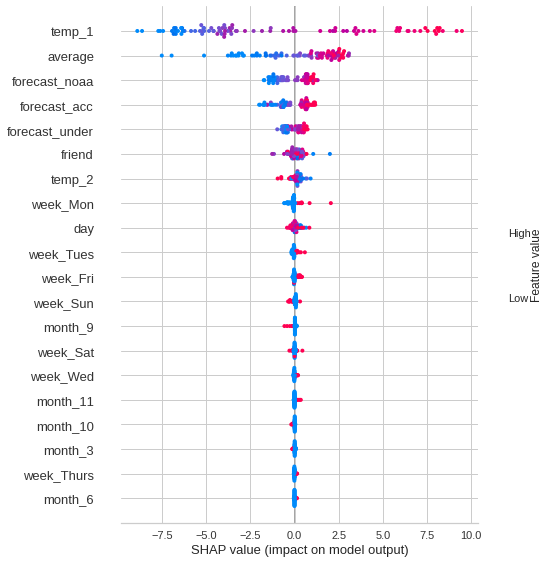

In [16]:
interpret_model(best)

# Evaluate More Metrics

PyCaret provides some awesome widget and plots to give you an easy way for visualizing and checking many other useful metrics during its training.

In [ ]:
evaluate_model(best)

# TroubleShooting

1. First time runners might meet this issue on M1: https://github.com/microsoft/LightGBM/issues/1369 Please reinstall pycaret and lightgbm and see if the problem is gone. If not, please create a new issue on the Github repository issue page.